In [23]:
import os
os.chdir("/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/Xenium/Baysor_test")

In [1]:
import tifffile
import scipy as scp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from matplotlib.patches import Polygon
import cv2
import json

mipurl = '/diskmnt/primary/Xenium/data/20240821__204457__20240821_SenNet_bone/output-XETG00122__0033739__SN151R1-Ma1Fd2-2U1__20240821__204528/morphology_focus/morphology_focus_0000.ome.tif'

with tifffile.TiffFile(mipurl) as tif:
    image = tif.series[0].levels[0].asarray()
print(image.shape)

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


(4, 27341, 28499)


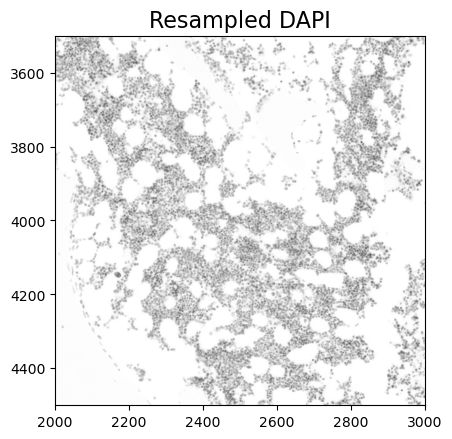

In [2]:
#### Plot inverted and resampled DAPI image
resample = scp.ndimage.zoom(image[0,...], 0.2125)

plt.imshow(resample, cmap='binary')
plt.title('Resampled DAPI', size=16)
plt.axis('scaled')
plt.xlim(2000, 3000)
plt.ylim(4500, 3500)
plt.show()

(np.float64(-0.5), np.float64(28498.5), np.float64(27340.5), np.float64(-0.5))

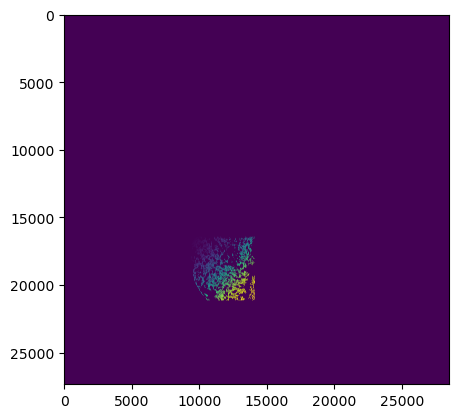

In [6]:
with open('parameter_sweep/mol5_size5_conf0.6/baysor_segmentation_polygons_2d.json', 'r') as f:
    geojson_data = json.load(f)

from shapely.geometry import Polygon
import rasterio
from rasterio import features

def create_segmentation_from_geojson(geojson_data, im_shape, microns_per_pixel=0.2125):
    """
    Convert GeoJSON polygons to a segmentation mask image
    
    Parameters:
    -----------
    geojson_data : dict
        GeoJSON data containing polygon features
    shape : tuple
        Output image shape (H, W)
    microns_per_pixel : float
        Conversion factor from microns to pixels
    
    Returns:
    --------
    mask : np.ndarray
        Integer mask where each pixel value is the cell_id
    """
    # Create empty mask
    mask = np.zeros(im_shape, dtype=np.int32)
    
    # Scale factor to convert from microns to pixels
    scale = 1/microns_per_pixel
    
    # Prepare geometry collection for rasterization
    geometries = []
    
    # Process each feature in the GeoJSON
    for feature in geojson_data['geometries']:
        # Get the cell ID (assuming it's stored in properties)
        cell_id = feature['cell']
        
        # Convert GeoJSON geometry to shapely
        geom = Polygon(feature['coordinates'][0])
        
        # Scale coordinates from microns to pixels
        scaled_coords = []
        for x, y in geom.exterior.coords:
            scaled_coords.append((x * scale, y * scale))
        
        # Create new scaled geometry
        scaled_geom = type(geom)(scaled_coords)
        
        # Add to collection with cell_id as value
        geometries.append((scaled_geom, cell_id))
    
    # Rasterize all geometries at once
    mask = features.rasterize(
        geometries,
        out_shape=im_shape,
        dtype=np.int32,
        all_touched=True
    )
    
    return mask

baysor_seg = create_segmentation_from_geojson(geojson_data, (image.shape[1], image.shape[2]))

plt.imshow(baysor_seg, cmap='viridis')
plt.axis('scaled')
#plt.xlim(10000, 12000)
#plt.ylim(10000, 12000)

In [11]:
baysor_seg_roi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(4706, 4705), dtype=int32)

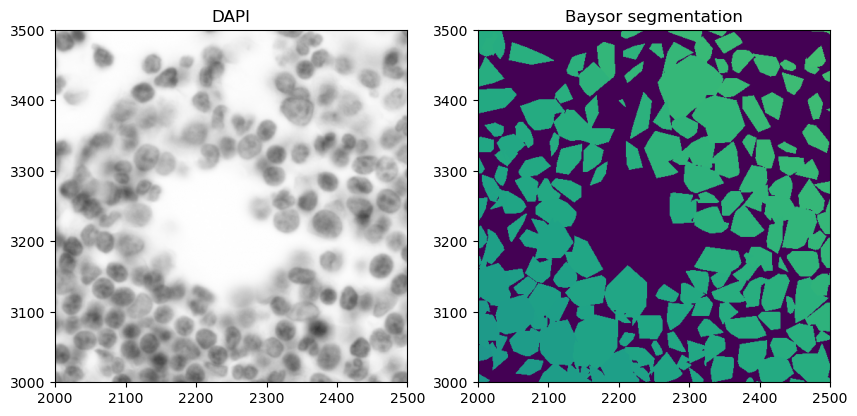

In [17]:
# Crop image and baysor_seg to the same ROI
# Define ROI
x1, x2 = round(2000/0.2125), round(3000/0.2125)
y1, y2 = round(3500/0.2125), round(4500/0.2125)

image_roi = image[:, y1:y2, x1:x2]
baysor_seg_roi = baysor_seg[y1:y2, x1:x2]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
ax[0].imshow(image_roi[0,...], cmap='binary')
ax[0].set_xlim(2000, 2500)
ax[0].set_ylim(3000, 3500)
plt.title('DAPI')

plt.subplot(1, 2, 2)
ax[1].imshow(baysor_seg_roi, cmap='viridis')
ax[1].set_xlim(2000, 2500)
ax[1].set_ylim(3000, 3500)
plt.title('Baysor segmentation')
plt.show()

In [24]:
# Runs through all parameter_sweep folders, make baysor segmentation, crop ROI, and save image
os.chdir("parameter_sweep")
# Define ROI
x1, x2 = round(2000/0.2125), round(3000/0.2125)
y1, y2 = round(3500/0.2125), round(4500/0.2125)

for folder in os.listdir():
    os.chdir(folder)
    
    with open('baysor_segmentation_polygons_2d.json', 'r') as f:
        geojson_data = json.load(f)

    baysor_seg = create_segmentation_from_geojson(geojson_data, (image.shape[1], image.shape[2]))
    baysor_seg_roi = baysor_seg[y1:y2, x1:x2]

    tifffile.imwrite('baysor_seg_roi.tif', baysor_seg_roi)
    os.chdir('..')